In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from UniversalUnconsciousness.data_utils import get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import convert_h5_string_array
from UniversalUnconsciousness.plot_utils import get_session_plot_info, load_font, plot_sensory_responses_etdc, plot_sensory_responses_acf
from UniversalUnconsciousness.sensory_responses import cosine_sim_corrmat, get_responses_etdc, get_responses_acf, get_sensory_responses_leverOddball, get_sensory_responses_propofol
from hydra import initialize, compose
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
import statsmodels.tsa.stattools as smt
from tqdm.auto import tqdm

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
data_save_dir = os.path.join(os.path.dirname(img_save_dir), 'sensory_responses')
os.makedirs(data_save_dir, exist_ok=True)
curve_colors = cfg.plotting.curve_colors
epoch_colors = cfg.plotting.epoch_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
verbose = False
agent_data = {}

for data_class, agent in tqdm(anesthetic_agent_list):
    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
doses = ['high']
dt = 0.001
for data_class, agent in tqdm(anesthetic_agent_list):
    if agent == 'propofol':
        # leadup = 100
        # response = 650
        # trial_type = 'toneOnly'

        leadup = 250
        response = 1000
        trial_type = 'toneOnly'

        # leadup = 250
        # response = 1500
        # trial_type = 'toneOnly'
    else:

        # leadup = 100
        # response = 200
        # trial_type = 'oddball'

        leadup = 250
        response = 1000
        trial_type = 'oddball'

        # leadup = 250
        # response = 1500
        # trial_type = 'oddball'
    
    filename = f'{agent}_{data_class}_{doses}_{trial_type}_sensory_responses_{leadup}_{response}.pkl'
    if os.path.exists(os.path.join(data_save_dir, filename)):
        sensory_responses = pd.read_pickle(os.path.join(data_save_dir, filename))
    else:
        session_lists = agent_data[(data_class, agent)]['session_lists']
        noise_filter_info = agent_data[(data_class, agent)]['noise_filter_info']
        cfg.params.data_class = data_class
        iterator = tqdm(total=np.sum([len(session_lists[monkey][dose]) for monkey in session_lists.keys() for dose in session_lists[monkey].keys()]))
        sensory_responses = {}
        for monkey in session_lists.keys():
            sensory_responses[monkey] = {}
            # for dose in session_lists[monkey]:
            for dose in doses:
                sensory_responses[monkey][dose] = {}
                for session in session_lists[monkey][dose]:
                    if 'propofol' in cfg.params.data_class:
                        responses, dt = get_sensory_responses_propofol(cfg, session, noise_filter_info, trial_type, leadup, response)
                        sensory_responses[monkey][dose][session] = responses
                    else:
                        tone_lfps, dt = get_sensory_responses_leverOddball(cfg, session, noise_filter_info, trial_type, leadup, response)
                        sensory_responses[monkey][dose][session] = tone_lfps
                    iterator.update(1)
        iterator.close()
        pd.to_pickle(sensory_responses, os.path.join(data_save_dir, filename))
    agent_data[(data_class, agent)]['sensory_responses'] = sensory_responses
    agent_data[(data_class, agent)]['dt'] = dt
    agent_data[(data_class, agent)]['leadup'] = leadup
    agent_data[(data_class, agent)]['response'] = response

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
n_delays = 1
delay_interval = 1
min_time = None
max_time = None
plot_return_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    # if agent in ['ketamine', 'dexmedetomidine']:
    #     min_time = -100
    #     max_time = 250
    # else:
    #     min_time = None
    #     max_time = None
    sensory_responses = agent_data[(data_class, agent)]['sensory_responses']
    leadup = agent_data[(data_class, agent)]['leadup']
    response = agent_data[(data_class, agent)]['response']
    dt = agent_data[(data_class, agent)]['dt']
    plot_return_data[(data_class, agent)] = plot_sensory_responses_etdc(
        agent, 
        curve_colors,
        epoch_colors,
        sensory_responses,
        leadup,
        response, 
        dt=dt, 
        n_delays=n_delays, 
        delay_interval=delay_interval, 
        plot_legend=True if 'dex' in agent else False, 
        save_path=os.path.join(img_save_dir, f'{agent}_sensory_responses_leverresponsetime_{response}_{min_time}_{max_time}.pdf'), 
        dims=1, 
        use_mean=True, 
        min_time=min_time, 
        max_time=max_time,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computing ACF:   0%|          | 0/63 [00:00<?, ?it/s]

Computing ACF:   0%|          | 0/48 [00:00<?, ?it/s]

Computing ACF:   0%|          | 0/48 [00:00<?, ?it/s]

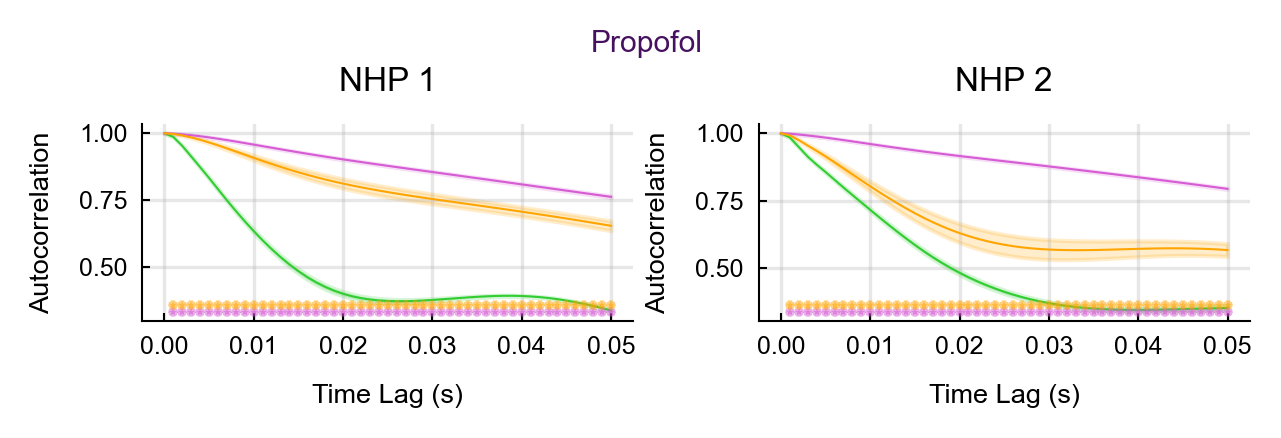

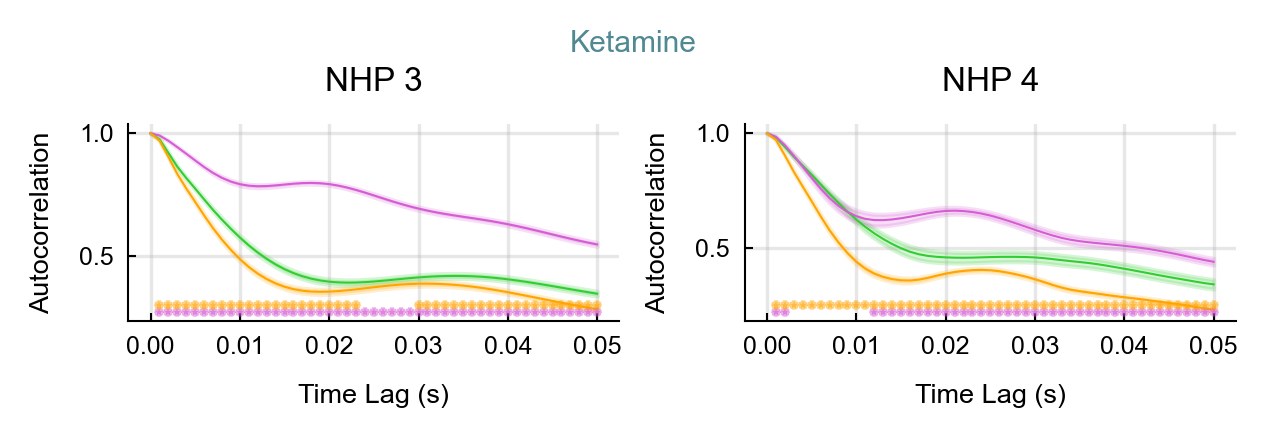

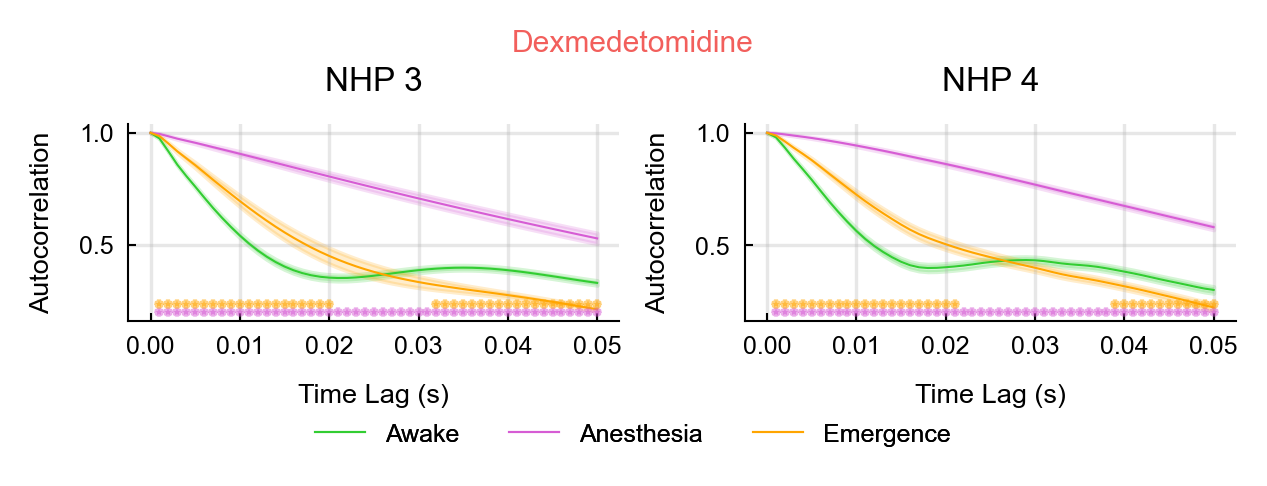

In [8]:
n_delays = 1
delay_interval = 1
plot_return_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    sensory_responses = agent_data[(data_class, agent)]['sensory_responses']
    leadup = agent_data[(data_class, agent)]['leadup']
    response = agent_data[(data_class, agent)]['response']
    dt = agent_data[(data_class, agent)]['dt']
    plot_return_data[(data_class, agent)] = plot_sensory_responses_acf(
        agent,
        curve_colors,
        epoch_colors,
        sensory_responses,
        leadup,
        response,
        dt=dt,
        n_delays=n_delays,
        delay_interval=delay_interval,
        plot_legend=True if 'dex' in agent else False,
        method='individual',
        n_ac_pts=None,
        verbose=True,
        save_path=os.path.join(img_save_dir, f'{agent}_sensory_responses_acf_{response}.pdf'),
        data_save_dir=data_save_dir
    )